* [Excercise 4.5. Jack's Car Rental](#Excercise-4.5.-Jack's-Car-Rental)
* [Excercise-4.5. Gambler's Problem](#Excercise-4.5.-Gambler's-Problem)

## Excercise 4.5. Jack's Car Rental

Other solutions:
* https://github.com/kkleidal/SuttonRLExercises/tree/master/chapters/4
* https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/tree/master/chapter04
* http://waxworksmath.com/Authors/N_Z/Sutton/WWW/chapter_4.html

In [1]:
import sys
import numpy as np
from scipy import stats
import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
poisson_cache = {}
def poisson(k, k_max, lam):
    """Truncated Poisson distribution"""
    global poisson_cache
    if (k, k_max, lam) in poisson_cache:
        return poisson_cache[(k, k_max, lam)]

    if k < k_max:
        p = stats.poisson.pmf(k, lam)
    elif k == k_max:
        # basically it's mass of the right tail
        p = 1 - stats.poisson.cdf(k_max-1, lam)
    else:
        assert False, 'k > k_max'
    
    poisson_cache[(k, k_max, lam)] = p
    return p

In [4]:
# MDP as per Example 4.2
class MDP(object):
    def __init__(self,
                 rent_reward=10,
                 transfer_cost=2,
                 expected_req1=3,
                 expected_req2=4,
                 expected_ret1=3,
                 expected_ret2=2,
                 max_parking=20,
                 max_transfer=5,
                 gamma=0.9):
        self.rent_reward = rent_reward
        self.transfer_cost = transfer_cost
        self.expected_req1 = expected_req1
        self.expected_req2 = expected_req2
        self.expected_ret1 = expected_ret1
        self.expected_ret2 = expected_ret2
        self.max_parking = max_parking
        self.max_transfer = max_transfer
        self.gamma = gamma
        
        self.policy = np.zeros((self.max_parking + 1,
                                self.max_parking + 1),
                                dtype=int)
        
        self.values = np.zeros((self.max_parking + 1,
                                self.max_parking + 1),
                                dtype=float)
        
        self.theta = 1.0 # threshold to stop policy evaluation 

    def transitions(self, n_cars, req_expected, ret_expected):
        """Iterator over all possible transitions from given number of cars"""
        p_total = 0.0
        for req in range(n_cars + 1):
            p_req = poisson(req, n_cars, req_expected)
            max_ret = self.max_parking - (n_cars - req)
            for ret in range(max_ret + 1):
                p_ret = poisson(ret, max_ret, ret_expected)
                yield req, p_req, ret, p_ret
                p_total += p_req * p_ret
        assert np.allclose(p_total, 1.0), 'Total probability must be 1.0'

    def states(self):
        """Iterator over all states"""
        for n1 in range(self.max_parking + 1):
            for n2 in range(self.max_parking + 1):
                yield n1, n2
    
    def actions_in_state(self, n1, n2):
        """Iterator over all actions in state"""
        assert n1 <= self.max_parking
        assert n2 <= self.max_parking

        for a in range(min(n1, self.max_transfer) + 1):
            if (a + n2) > self.max_parking:
                break
            yield a
        
        # since a=0 was already yielded, start with 1
        for a in range(1, min(n2, self.max_transfer) + 1):
            if (a + n1) > self.max_parking:
                break
            yield -a
    
    def q_value(self, n1, n2, action):
        q = -self.transfer_cost * abs(action)
        n1_post = n1 - action
        n2_post = n2 + action

        assert n1_post >= 0, 'n1_post >= 0'
        assert n2_post >= 0, 'n2_post >= 0'
        assert n1_post <= self.max_parking, 'n1_post <= self.max_parking'
        assert n2_post <= self.max_parking, 'n2_post <= self.max_parking'

        for req1, p_req1, ret1, p_ret1 in self.transitions(n1_post,
                                                           self.expected_req1,
                                                           self.expected_ret1):
            for req2, p_req2, ret2, p_ret2 in self.transitions(n2_post,
                                                               self.expected_req2,
                                                               self.expected_ret2):
                p = p_req1 * p_ret1 * p_req2 * p_ret2                
                r = self.rent_reward * (req1 + req2)

                n1_next = n1_post - req1 + ret1
                n2_next = n2_post - req2 + ret2

                assert n1_next >= 0, 'n1_next >= 0'
                assert n2_next >= 0, 'n2_next >= 0'
                assert n1_next <= self.max_parking, 'n1_next <= self.max_parking'
                assert n2_next <= self.max_parking, 'n2_next <= self.max_parking'

                q += p * (r + self.gamma * self.values[n1_next, n2_next])
        return q

    def policy_evaluation(self):
        while True:
            values_new = np.zeros_like(self.values)
            for n1, n2 in self.states():
                action = self.policy[n1, n2]
                q = self.q_value(n1, n2, action)
                values_new[n1,n2] = q
            
            diff = np.abs(values_new - self.values)
            max_diff = np.max(diff)
            
            self.values = values_new
            sys.stdout.write('.')
            if max_diff < self.theta:
                break
        sys.stdout.write('\n')
            
    def policy_improvement(self):
        changed = False
        for n1, n2 in self.states():
            actions = list(self.actions_in_state(n1, n2))
            qs = list(map(lambda a: self.q_value(n1, n2, a), actions))
            best_a = actions[np.argmax(qs)]
            if self.policy[n1,n2] != best_a:
                changed = True
                self.policy[n1,n2] = best_a
        return changed
    
    def policy_iteration(self):
        i = 0
        while True:
            print('policy iteration', i)
            self.policy_evaluation()
            changed = self.policy_improvement()
            
            if not changed:
                break
            i += 1

In [5]:
mdp1 = MDP(max_parking=20)
mdp1.policy_iteration()

policy iteration 0
......................................
policy iteration 1
.........
policy iteration 2
.........
policy iteration 3
..
policy iteration 4
.
policy iteration 5
.


In [15]:
def visualize(mdp):
    height = mdp.policy.shape[0]
    width = mdp.policy.shape[1]
    
    y_ticks = np.arange(height) + 0.5
    x_ticks = np.arange(width) + 0.5
    y_labels = np.arange(height + 1)
    x_labels = np.arange(width + 1)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))    
    ax = axs[0]
    pc = ax.pcolor(mdp.policy)
    fig.colorbar(pc, ax=ax)
    ax.set_yticks(y_ticks)
    ax.set_xticks(x_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_xticklabels(x_labels)
    ax.set_title('policy')
    
    ax = axs[1]
    pc = ax.pcolor(mdp.values)
    fig.colorbar(pc, ax=ax)
    ax.set_yticks(y_ticks)
    ax.set_xticks(x_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_xticklabels(x_labels)
    ax.set_title('values')
    
    plt.show()

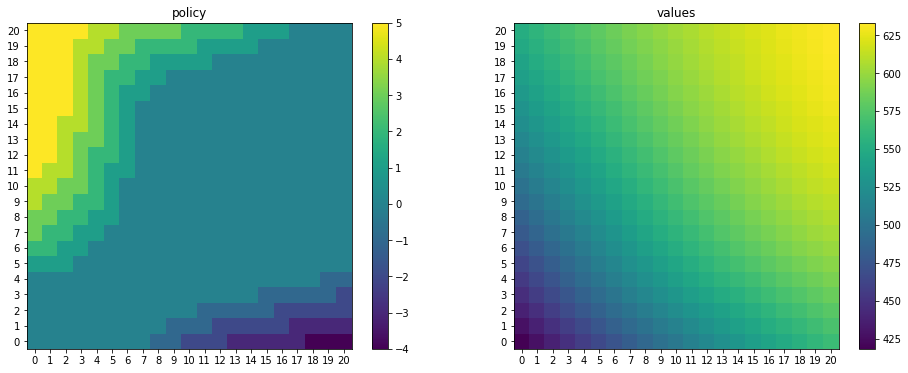

In [16]:
visualize(mdp1)

In [8]:
# MDP as per Exercise 4.5
class MDP_ex45(MDP):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def q_value(self, n1, n2, action):
        q = 0.0
        if action < 0:
            # one car will be driven by employee from the second location to the first
            q -= self.transfer_cost * (abs(action) - 1)
        else:
            q -= self.transfer_cost * abs(action)

        n1_post = n1 - action
        n2_post = n2 + action
        
        if n1_post > 10:
            # pay for extra parking
            q -= 4
            
        if n2_post > 10:
            # pay for extra parking
            q -= 4

        assert n1_post >= 0, 'n1_post >= 0'
        assert n2_post >= 0, 'n2_post >= 0'
        assert n1_post <= self.max_parking, 'n1_post <= self.max_parking'
        assert n2_post <= self.max_parking, 'n2_post <= self.max_parking'

        for req1, p_req1, ret1, p_ret1 in self.transitions(n1_post,
                                                           self.expected_req1,
                                                           self.expected_ret1):
            for req2, p_req2, ret2, p_ret2 in self.transitions(n2_post,
                                                               self.expected_req2,
                                                               self.expected_ret2):
                p = p_req1 * p_ret1 * p_req2 * p_ret2                
                r = self.rent_reward * (req1 + req2)

                n1_next = n1_post - req1 + ret1
                n2_next = n2_post - req2 + ret2

                assert n1_next >= 0, 'n1_next >= 0'
                assert n2_next >= 0, 'n2_next >= 0'
                assert n1_next <= self.max_parking, 'n1_next <= self.max_parking'
                assert n2_next <= self.max_parking, 'n2_next <= self.max_parking'

                q += p * (r + self.gamma * self.values[n1_next, n2_next])
        return q

In [9]:
mdp2 = MDP_ex45(max_parking=20)

In [10]:
mdp2.policy_iteration()

policy iteration 0
......................................
policy iteration 1
............
policy iteration 2
..........
policy iteration 3
..
policy iteration 4
.


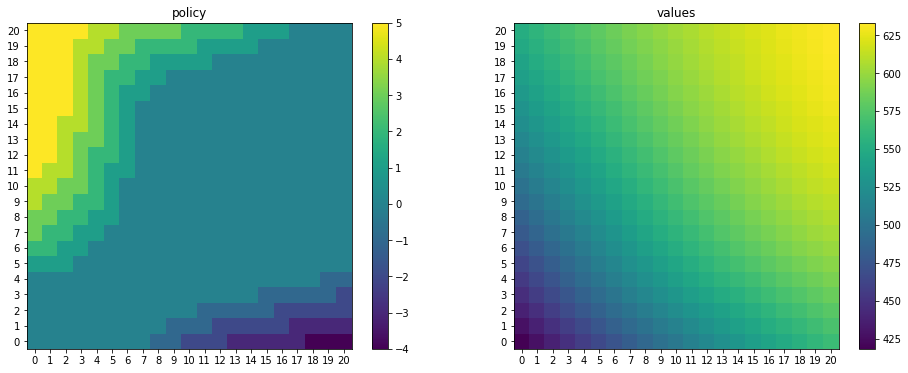

In [17]:
visualize(mdp1)

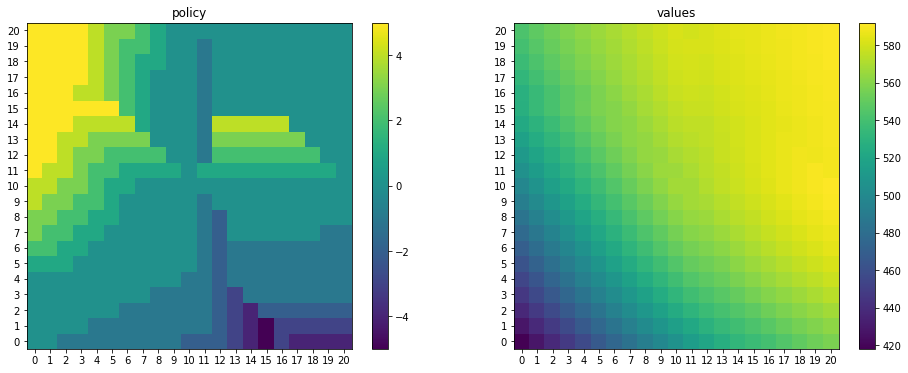

In [18]:
visualize(mdp2)

## Excercise 4.5. Gambler's Problem

In [172]:
MAX_CAPITAL = 100
class GamblerMDP(object):
    def __init__(self, p_coin=0.4, theta=0.001):
        self.p_coin = p_coin
        self.theta = theta
        
        state_size = (MAX_CAPITAL + 1,)
        
        self.values = np.zeros(state_size, dtype=float)
        self.policy = np.zeros(state_size, dtype=float)
        
    def states(self):
        """Iterate over all non-terminal states"""
        # 1..99
        for s in range(1, MAX_CAPITAL):
            yield s
            
    def transitions(self, state, action):
        if state in (0, MAX_CAPITAL) or action == 0:
            yield state, 1.0, 0 # next_state, p_next_state, reward
            return
        
        # winning round
        next_state = state + action
        assert next_state <= MAX_CAPITAL
        reward = 1 if next_state == MAX_CAPITAL else 0
        yield next_state, self.p_coin, reward
        
        # losing round
        next_state = state - action
        assert next_state >= 0
        yield next_state, 1 - self.p_coin, 0
        
    def actions(self, state):
        if state == 0 or state == MAX_CAPITAL:
            yield 0
            return
        
        for a in range(1, min(state, MAX_CAPITAL - state)+1):
            yield a
            
    def q_values(self, state):
        """Calc all possible q-values for `state`"""
        qs = [] # action values
        actions = []
        for a in self.actions(state):
            q = 0.0 # action value, Q(s,a)
            p_total = 0.0 # total proba for all possible transitions
            for next_state, p_next, r in self.transitions(state, a):
                q += p_next * (r + self.values[next_state])
                p_total += p_next
            assert np.allclose(p_total, 1.0)
            qs.append(q)
            actions.append(a)
        return qs, actions
            
    def value_iteration(self):
        while True:
            sys.stdout.write('.')
            delta = 0.0
            for s in self.states():
                v_old = self.values[s]
                qs, actions = self.q_values(s)
                v_new = np.max(qs)
                self.values[s] = v_new
                
                delta = max(delta, np.abs(v_new - v_old))
            if delta < self.theta:
                break
        sys.stdout.write('\n')
                
    def update_policy(self):
        for s in self.states():
            qs, actions = self.q_values(s)
            a_id = np.argmax(qs)
            self.policy[s] = actions[a_id]
            

In [174]:
def visualize_gambler(values, policy):
    f, axs = plt.subplots(1,2,figsize=(14,6))
    x = np.arange(policy.shape[0])
    ax = axs[0]
    ax.step(x, values)
    ax.grid()
    ax.set_title('values')
    ax.set_xlabel('states')
    ax.set_ylabel('probability of winning')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.set_yticks(np.arange(0, 1.1, 0.1))


    ax = axs[1]
    ax.step(x, policy)
    ax.grid()
    ax.set_title('policy')
    ax.set_xlabel('states')
    ax.set_ylabel('action, stake')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.set_yticks(np.arange(0, 60, 5))
    plt.show()

...........


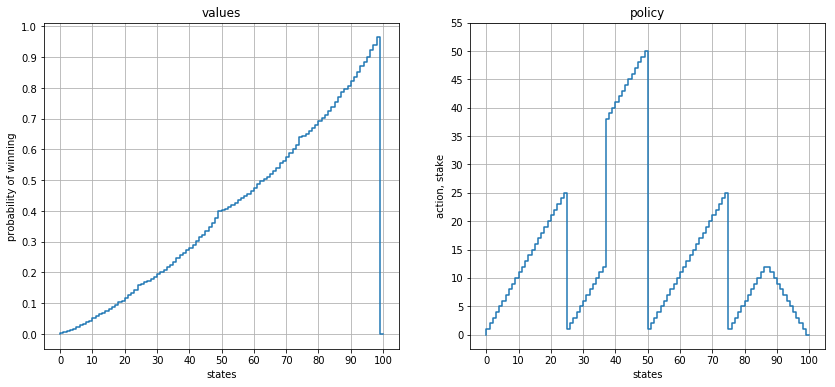

In [187]:
gambler = GamblerMDP(p_coin=0.4, theta=0.00001)
gambler.value_iteration()
gambler.update_policy()
visualize_gambler(gambler.values, gambler.policy)

.........


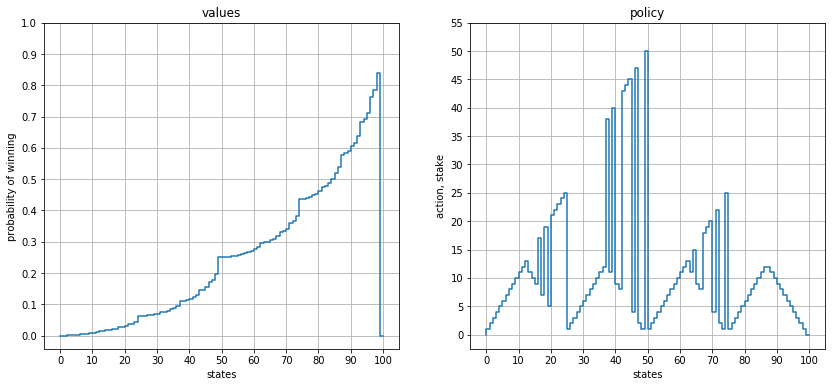

In [188]:
gambler = GamblerMDP(p_coin=0.25, theta=0.00001)
gambler.value_iteration()
gambler.update_policy()
visualize_gambler(gambler.values, gambler.policy)

.................................


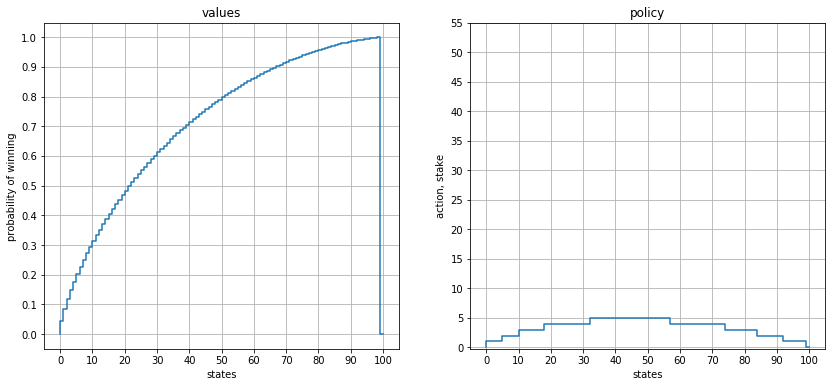

In [194]:
gambler = GamblerMDP(p_coin=0.55, theta=0.005)
gambler.value_iteration()
gambler.update_policy()
visualize_gambler(gambler.values, gambler.policy)